In [1]:
!pip install -q segmentation-models-pytorch

import os
from glob import glob
from tqdm import tqdm
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T

In [2]:
#settings
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(18)
torch.manual_seed(18)
torch.cuda.manual_seed(18)

In [3]:
#path
folder_dir="/kaggle/input/lgg-mri-segmentation/kaggle_3m"
image_files_path=glob(f"{folder_dir}/*/*[0-9].tif")

In [4]:
#create dataframe
data=[]
for path in image_files_path:
    image_path_noex,ex=os.path.splitext(path)
    mask_path_noex=image_path_noex+"_mask"
    file_name=os.path.basename(path)
    patient="_".join(file_name.split("_")[:3])
    mask_path=mask_path_noex+ex
    data.append((patient,path,mask_path))
    
files_df=pd.DataFrame(data,columns=['Patient', 'image_filename', 'mask_filename'])
files_df

Patient                                     image_filename  \
0     TCGA_DU_7010  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1     TCGA_DU_7010  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2     TCGA_DU_7010  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3     TCGA_DU_7010  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4     TCGA_DU_7010  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
...            ...                                                ...   
3924  TCGA_DU_7306  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3925  TCGA_DU_7306  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3926  TCGA_DU_7306  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3927  TCGA_DU_7306  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3928  TCGA_DU_7306  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                          mask_filename  
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
...                                                 ...  
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  

[3929 rows x 3 columns]

In [5]:
#transforms and dataset function
train_transforms=A.Compose([
    A.Resize(256,256),
    A.ColorJitter(p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
])
test_transforms=A.Compose([
        A.Resize(256,256)
])

class MRIdataset(Dataset):
    def __init__(self,df,transforms=None):
        super().__init__()
        self.df=df
        self.transforms=transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx,raw=False):
        row=self.df.iloc[idx]
        image=cv2.imread(row["image_filename"],cv2.IMREAD_UNCHANGED)
        mask=cv2.imread(row["mask_filename"],cv2.IMREAD_GRAYSCALE)
        if raw:
            return image,mask
        
        if self.transforms:
            augmented=self.transforms(image=image,mask=mask)
            image,mask=augmented["image"],augmented["mask"]
        
        image=image/255.0
        image=np.transpose(image,(2,0,1))
        image=torch.from_numpy(image).type(torch.float32)
        mask=mask/255.0
        mask=np.expand_dims(mask,axis=-1).transpose((2,0,1))
        mask=torch.from_numpy(mask).type(torch.float32)
        
        return image,mask

In [6]:
#train_test_split and create dataset
train_df,val_test_df=train_test_split(files_df,test_size=0.3)
val_df,test_df=train_test_split(val_test_df,test_size=0.5)

train_dataset=MRIdataset(train_df,train_transforms)
valid_dataset=MRIdataset(val_df,test_transforms)
test_dataset=MRIdataset(test_df,test_transforms)

print("train_dataset: ",len(train_dataset))
print("valid_dataset: ",len(valid_dataset))
print("test_dataset: ",len(test_dataset))
print("image shape:",train_dataset[0][0].shape)
print("mask shape:",train_dataset[0][1].shape)

train_dataset:  2750
valid_dataset:  589
test_dataset:  590
image shape: torch.Size([3, 256, 256])
mask shape: torch.Size([1, 256, 256])


In [7]:
#create dataloader
batch_size=8

train_loader=DataLoader(train_dataset,batch_size=batch_size,num_workers=2,shuffle=True)
valid_loader=DataLoader(valid_dataset,batch_size=batch_size,num_workers=2,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=1,num_workers=2)

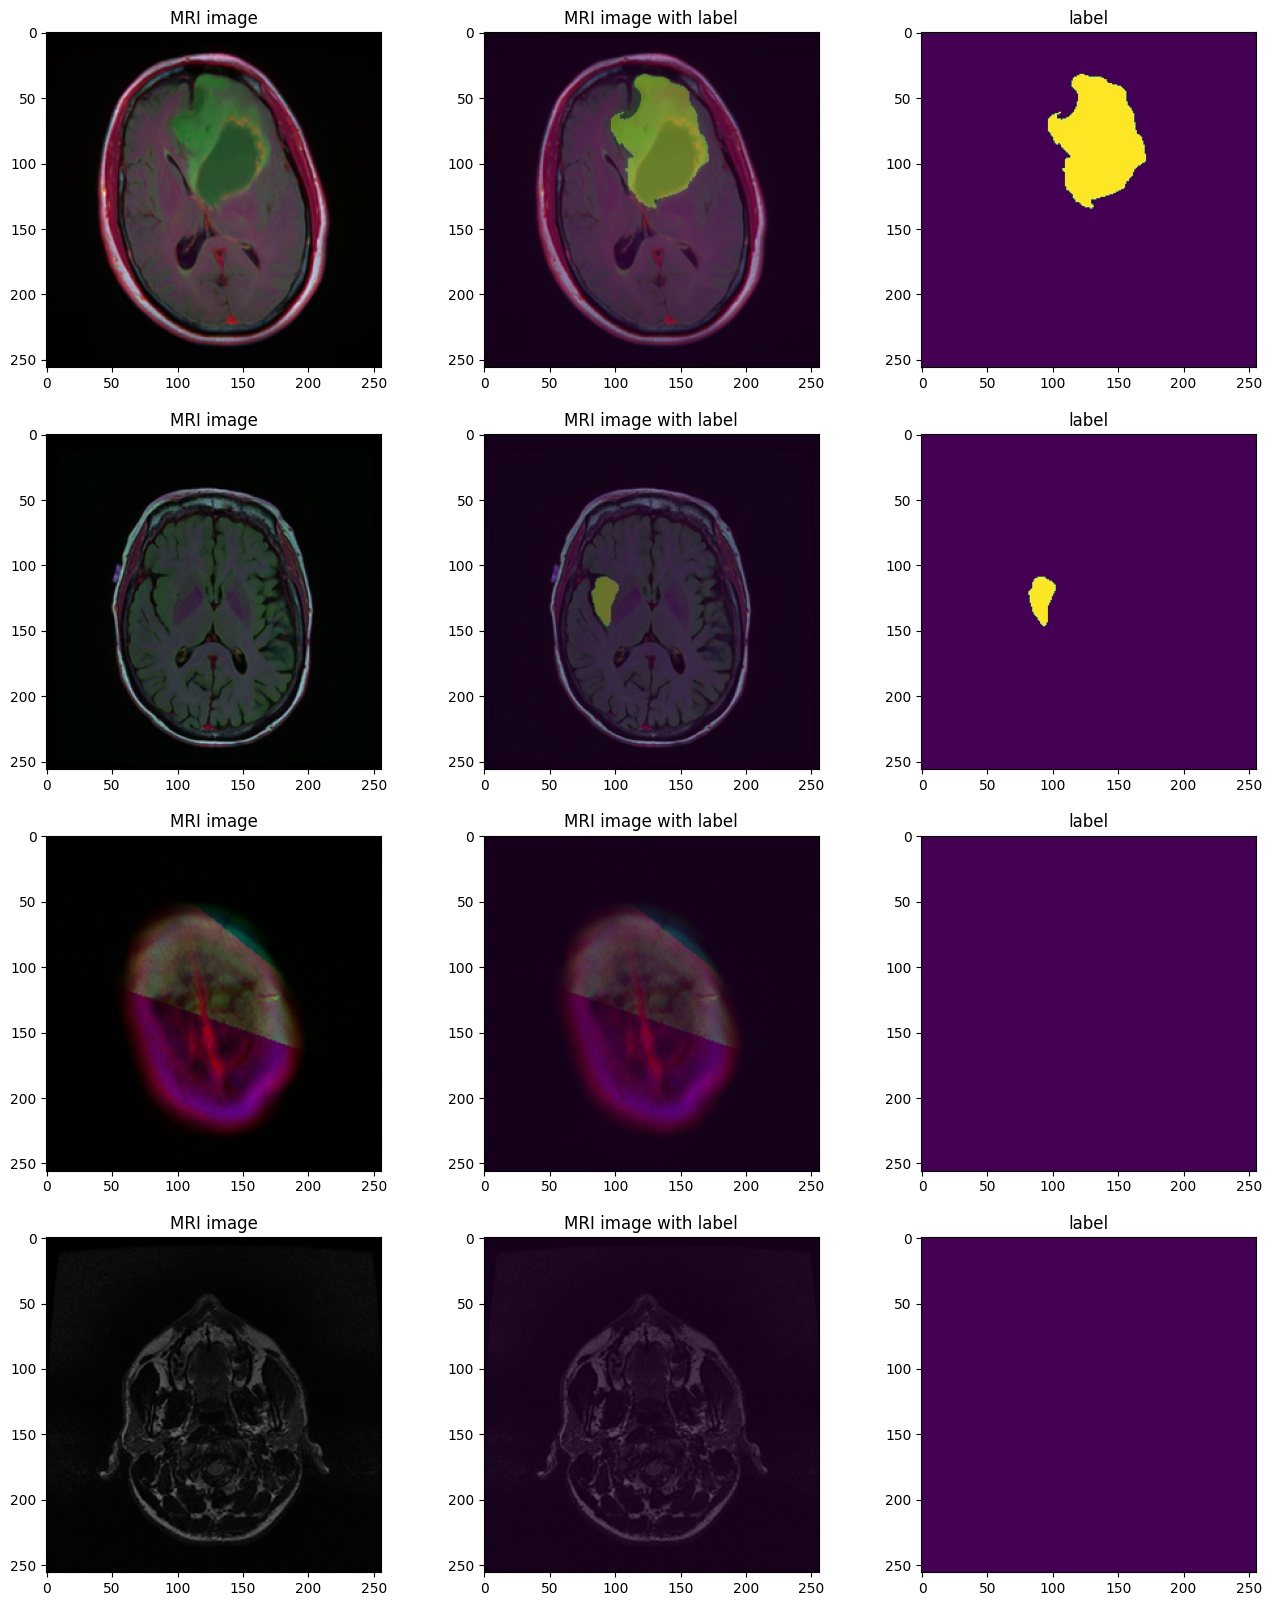

In [8]:
#view images and masks
fig,ax=plt.subplots(nrows=4,ncols=3,figsize=(16,20))
image_ids=np.random.choice(len(train_dataset),4,replace=False)
for i,id in enumerate(image_ids):
    image,mask=train_dataset.__getitem__(id,raw=True)
    ax[i,0].set_title("MRI image")
    ax[i,0].imshow(image)
    ax[i,1].set_title("MRI image with label")
    ax[i,1].imshow(image)
    ax[i,1].imshow(mask,alpha=0.3)
    ax[i,2].set_title("label")
    ax[i,2].imshow(mask)
plt.show()

In [9]:
#define models
model_a=smp.Unet(
    encoder_name="efficientnet-b7",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None
)

model_b=smp.Unet(
    encoder_name="mobilenet_v2",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None
)


models=list((model_a,model_b))
model_a.to(device)
model_b.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:00<00:00, 338MB/s] 
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 42.9MB/s]


Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

In [10]:
#check models output shape
output_a=model_a(torch.randn(1,3,256,256).to(device))
output_b=model_b(torch.randn(1,3,256,256).to(device))

print(output_a.shape)
print(output_b.shape)

torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])


In [11]:
#train,valid,pred functions 
def train_step(model,optimizer,criterion,dataloader):
    model.train()
    epoch_loss=0.0
    batch_size=len(dataloader)
    for i,batch in enumerate(dataloader):
        images,masks=batch
        images=images.to(device)
        masks=masks.to(device)
        optimizer.zero_grad()
        preds=model(images)
        loss=criterion(preds,masks)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss+=loss.item()
    
    return epoch_loss/batch_size
        

def valid_step(model,criterion,dataloader):
    model.eval()
    epoch_loss=0.0
    batch_size=len(dataloader)
    with torch.no_grad():
        for i,batch in enumerate(dataloader):
            images,masks=batch
            images=images.to(device)
            masks=masks.to(device)
            preds=model(images)
            loss=criterion(preds,masks)
            
            epoch_loss+=loss.item()
            
        return epoch_loss/batch_size
    
    
def train_validation(model,optimizer,criterion,scheduler,train_dataloader,valid_dataloader):
    logs={"train_loss":[],"valid_loss":[]}
    epochs=50
    patience=5
    counter=0
    best_loss=np.inf
    for epoch in range(epochs):
        train_loss=train_step(model,optimizer,criterion,train_dataloader)
        valid_loss=valid_step(model,criterion,valid_dataloader)
        logs["train_loss"].append(train_loss)
        logs["valid_loss"].append(valid_loss)
        print(f"Epoch:{epoch+1} train_loss:{train_loss:.4f} valid_loss:{valid_loss:.4f}")
        
        scheduler.step(valid_loss)
        if valid_loss<best_loss:
            counter=0
            best_loss=valid_loss
        else:
            counter+=1
            
        if counter>=patience:
            print("Early Stopping!!")
            break
            
    return logs


def ensemble_pred(models,dataloader,num_images):
    fig,ax=plt.subplots(nrows=num_images,ncols=3,figsize=(15,100))
    num_models=len(models)
    preds=[]
    predicted_image=0
    for i,data in enumerate(dataloader):
        predicted_image+=1
        image,mask=data
        image=image.to(device)
        mask=mask.to(device)
        with torch.no_grad():
            models[0].eval()
            models[0].to(device)
            models[1].eval()
            models[1].to(device)
            pred_a=models[0](image)
            pred_b=models[1](image)
        
        image=image.squeeze(0)
        mask=mask.squeeze(0)
        output=(0.7*pred_a+0.3*pred_b).to(device)
        output=output.squeeze(0)
        ax[i,0].set_title('image_with_mask')
        ax[i,0].set_axis_off()
        ax[i,0].imshow(image.cpu().permute(1,2,0))
        ax[i,0].imshow(mask.cpu().permute(1,2,0),alpha=0.3)
        ax[i,1].set_title('image_with_pred')
        ax[i,1].set_axis_off()
        ax[i,1].imshow(image.cpu().permute(1,2,0))
        ax[i,1].imshow(output.cpu().permute(1,2,0),alpha=0.3)
        ax[i,2].set_title('image_with_binary_pred')
        ax[i,2].set_axis_off()
        ax[i,2].imshow(image.cpu().permute(1,2,0))
        ax[i,2].imshow((output > 0.5).cpu().permute(1,2,0),alpha=0.3)
        
        if predicted_image==num_images:
            break
    
    plt.tight_layout()
    plt.show()


In [12]:
#model settings
optimizer_a=optim.Adam(model_a.parameters(),lr=0.001)
optimizer_b=optim.Adam(model_b.parameters(),lr=0.001)
scheduler_a=ReduceLROnPlateau(optimizer=optimizer_a,mode="min",factor=0.1,patience=2,min_lr=0.00001)
scheduler_b=ReduceLROnPlateau(optimizer=optimizer_b,mode="min",factor=0.1,patience=2,min_lr=0.00001)
criterion=smp.losses.DiceLoss(mode="binary")

In [13]:
#model_a training
a_logs=train_validation(model_a,optimizer_a,criterion,scheduler_a,train_loader,valid_loader)

Epoch:1 train_loss:0.4432 valid_loss:0.9174
Epoch:2 train_loss:0.2573 valid_loss:0.2133
Epoch:3 train_loss:0.2338 valid_loss:0.2773
Epoch:4 train_loss:0.2078 valid_loss:0.1586
Epoch:5 train_loss:0.2222 valid_loss:0.1516
Epoch:6 train_loss:0.2203 valid_loss:0.1663
Epoch:7 train_loss:0.1701 valid_loss:0.1432
Epoch:8 train_loss:0.1661 valid_loss:0.1661
Epoch:9 train_loss:0.1919 valid_loss:0.1397
Epoch:10 train_loss:0.1715 valid_loss:0.1442
Epoch:11 train_loss:0.1997 valid_loss:0.1363
Epoch:12 train_loss:0.1711 valid_loss:0.1292
Epoch:13 train_loss:0.2132 valid_loss:0.1747
Epoch:14 train_loss:0.1766 valid_loss:0.2355
Epoch:15 train_loss:0.1721 valid_loss:0.1292
Epoch:16 train_loss:0.1619 valid_loss:0.1384
Epoch:17 train_loss:0.1509 valid_loss:0.1239
Epoch:18 train_loss:0.1777 valid_loss:0.1641
Epoch:19 train_loss:0.1611 valid_loss:0.1447
Epoch:20 train_loss:0.1664 valid_loss:0.1288
Epoch:21 train_loss:0.1363 valid_loss:0.1054
Epoch:22 train_loss:0.1318 valid_loss:0.1178
Epoch:23 train_loss

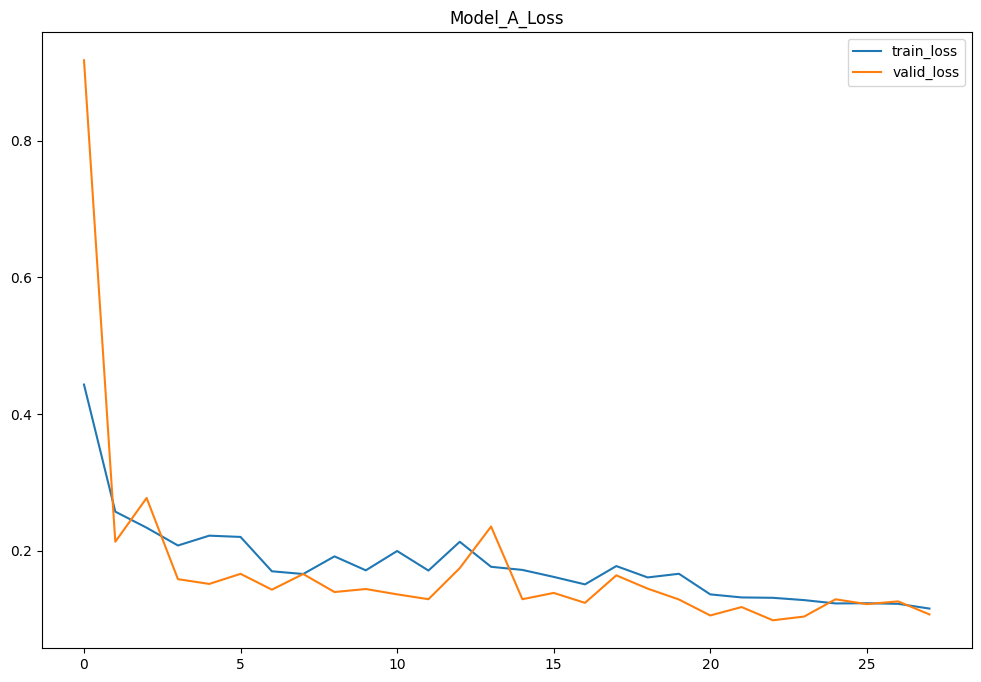

In [14]:
#view model_a loss
plt.figure(figsize=(12,8))
plt.plot(a_logs["train_loss"],label="train_loss")
plt.plot(a_logs["valid_loss"],label="valid_loss")
plt.title("Model_A_Loss")
plt.legend()

plt.show()

In [15]:
#model_b training
b_logs=train_validation(model_b,optimizer_b,criterion,scheduler_b,train_loader,valid_loader)

Epoch:1 train_loss:0.5557 valid_loss:0.4062
Epoch:2 train_loss:0.4094 valid_loss:0.3103
Epoch:3 train_loss:0.3504 valid_loss:0.3011
Epoch:4 train_loss:0.3376 valid_loss:0.2777
Epoch:5 train_loss:0.2972 valid_loss:0.2693
Epoch:6 train_loss:0.3209 valid_loss:0.2280
Epoch:7 train_loss:0.2874 valid_loss:0.2804
Epoch:8 train_loss:0.2852 valid_loss:0.2486
Epoch:9 train_loss:0.3100 valid_loss:0.3106
Epoch:10 train_loss:0.2721 valid_loss:0.2220
Epoch:11 train_loss:0.2492 valid_loss:0.2111
Epoch:12 train_loss:0.2326 valid_loss:0.1918
Epoch:13 train_loss:0.2274 valid_loss:0.1666
Epoch:14 train_loss:0.2128 valid_loss:0.1579
Epoch:15 train_loss:0.2253 valid_loss:0.1732
Epoch:16 train_loss:0.2047 valid_loss:0.1731
Epoch:17 train_loss:0.2089 valid_loss:0.1607
Epoch:18 train_loss:0.1986 valid_loss:0.1594
Epoch:19 train_loss:0.1870 valid_loss:0.1410
Epoch:20 train_loss:0.1999 valid_loss:0.1960
Epoch:21 train_loss:0.1881 valid_loss:0.1707
Epoch:22 train_loss:0.1913 valid_loss:0.1654
Epoch:23 train_loss

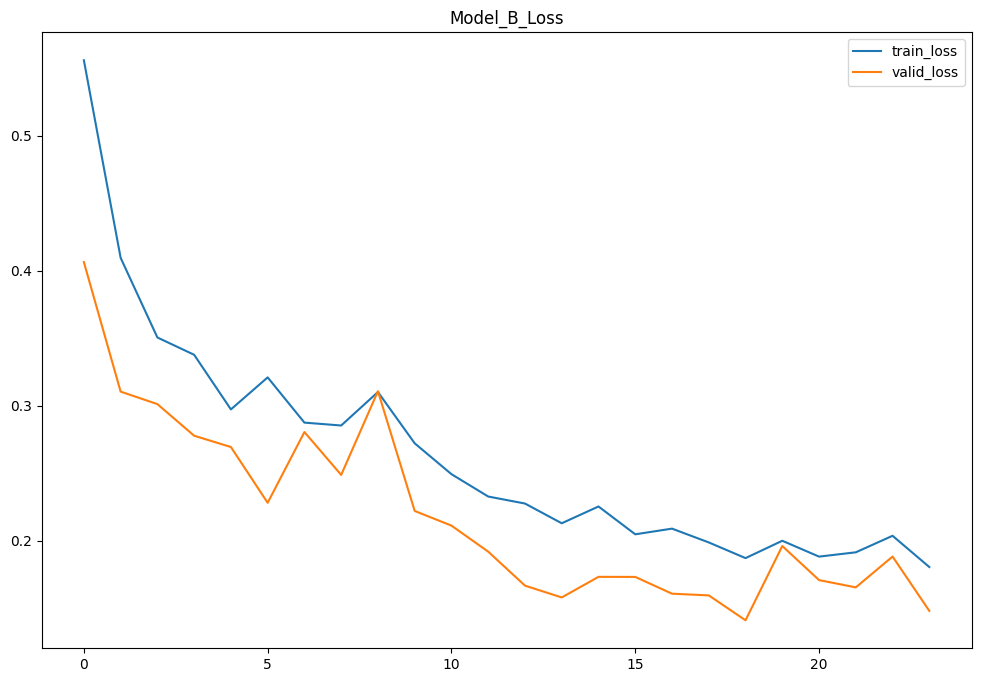

In [16]:
#view model_b loss
plt.figure(figsize=(12,8))
plt.plot(b_logs["train_loss"],label="train_loss")
plt.plot(b_logs["valid_loss"],label="valid_loss")
plt.title("Model_B_Loss")
plt.legend()

plt.show()

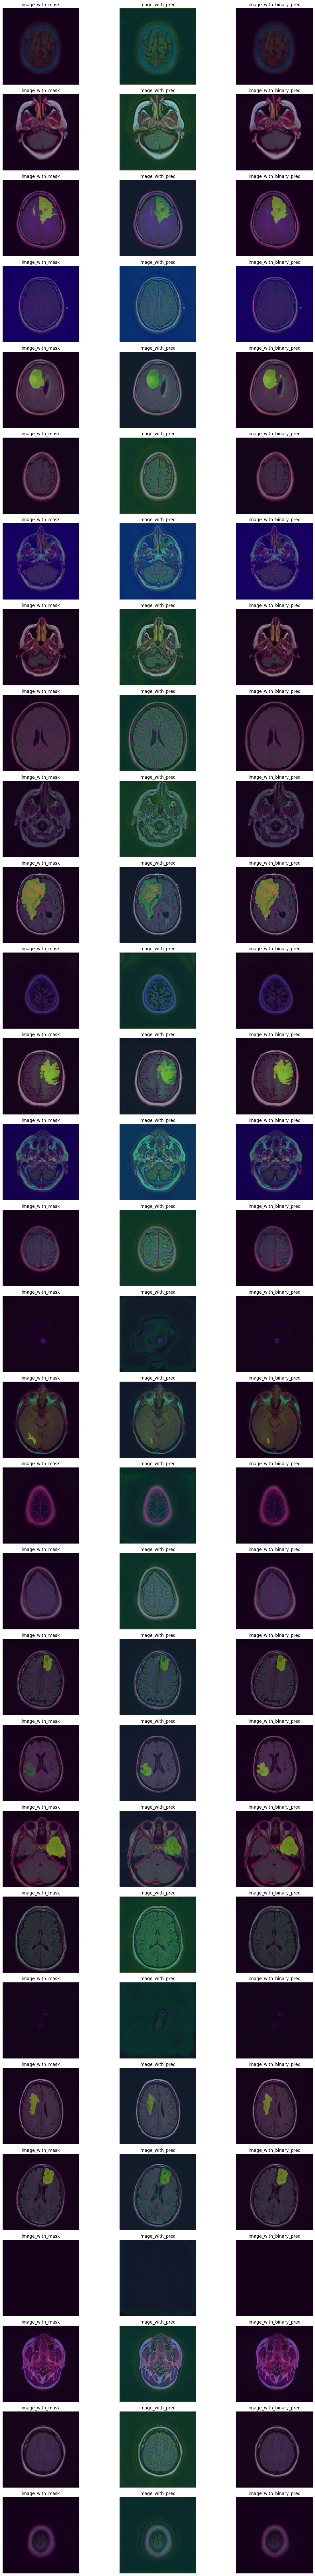

In [17]:
#ensemble_prediction and viewing
ensemble_pred(models,test_loader,30)